in this code i am just getting the column names for sex, mouse id, and trial from the file name and putting them into a csv file 

In [ ]:
import os, re, glob
import pandas as pd

CSV_DIR = '/Users/carolinalangaro/Desktop/Data BM SLEAP'
OVERWRITE = True                      # set False to write *_with_meta.csv instead

# Sex rules
ID_FEMALE = range(101, 104)  # 101–103
ID_MALE   = range(104, 107)  # 104–106

# Main pattern for names:
PAT = re.compile(
    r"""^labels\.v\d+\.(?P<file_index>\d+)_    # labels.v001.<file_index>_
        (?P<mouse_id>\d+)\.                    # <mouse_id>.
        (?P<trial>\d+)                         # <trial>
        \.?_cfr\.analysis\.csv$               # optional extra dot + _cfr.analysis.csv
    """,
    re.IGNORECASE | re.VERBOSE,
)

def parse_meta_from_name(basename: str):
    m = PAT.match(basename)
    if not m:
        return None
    file_index = int(m.group("file_index"))
    mouse_id   = int(m.group("mouse_id"))
    trial      = int(m.group("trial"))
    sex = "Female" if mouse_id in ID_FEMALE else ("Male" if mouse_id in ID_MALE else "Unknown")
    return file_index, mouse_id, trial, sex

csvs = sorted(glob.glob(os.path.join(CSV_DIR, "*.csv")))
print(f"Found {len(csvs)} CSV files in {CSV_DIR}")

unmatched = []
done = 0

for fp in csvs:
    base = os.path.basename(fp)
    parsed = parse_meta_from_name(base)
    if parsed is None:
        unmatched.append(base)
        continue

    file_index, mouse_id, trial, sex = parsed
    df = pd.read_csv(fp)

    # Add/overwrite meta columns
    df["file"]       = base
    df["file_index"] = file_index
    df["mouse_id"]   = mouse_id
    df["trial"]      = trial
    df["sex"]        = sex

    if OVERWRITE:
        out_fp = fp
    else:
        root, ext = os.path.splitext(fp)
        out_fp = root + "_with_meta" + ext

    df.to_csv(out_fp, index=False)
    done += 1
    print(f"✓ meta added: {base}  ->  {os.path.basename(out_fp)}")

print(f"\nCompleted: {done} files updated.")
if unmatched:
    print("\n⚠️  These filenames did not match the expected pattern; please check:")
    for name in unmatched:
        print("  -", name)

Found 38 CSV files in /Users/carolinalangaro/Desktop/Data BM SLEAP
✓ meta added: labels.v001.000_101.1_cfr.analysis.csv  ->  labels.v001.000_101.1_cfr.analysis.csv
✓ meta added: labels.v001.001_101.2_cfr.analysis.csv  ->  labels.v001.001_101.2_cfr.analysis.csv
✓ meta added: labels.v001.002_101.3_cfr.analysis.csv  ->  labels.v001.002_101.3_cfr.analysis.csv
✓ meta added: labels.v001.003_101.4_cfr.analysis.csv  ->  labels.v001.003_101.4_cfr.analysis.csv
✓ meta added: labels.v001.004_101.5_cfr.analysis.csv  ->  labels.v001.004_101.5_cfr.analysis.csv
✓ meta added: labels.v001.005_101.6_cfr.analysis.csv  ->  labels.v001.005_101.6_cfr.analysis.csv
✓ meta added: labels.v001.006_102.1_cfr.analysis.csv  ->  labels.v001.006_102.1_cfr.analysis.csv
✓ meta added: labels.v001.007_102.2_cfr.analysis.csv  ->  labels.v001.007_102.2_cfr.analysis.csv
✓ meta added: labels.v001.008_102.3_cfr.analysis.csv  ->  labels.v001.008_102.3_cfr.analysis.csv
✓ meta added: labels.v001.009_102.4_cfr.analysis.csv  ->  la

In [ ]:
import os, glob, h5py, numpy as np, pandas as pd

ROOT   = "/Users/carolinalangaro/Desktop/Data BM SLEAP"
CSV_IN = ROOT   
H5_DIR = ROOT 
OUTDIR = ROOT

os.makedirs(OUTDIR, exist_ok=True)

def h5_frames(h5_path: str) -> int:
    """Return total number of frames T from a SLEAP .analysis.h5 file."""
    with h5py.File(h5_path, "r") as f:
        if "tracks" in f:
            arr = np.squeeze(f["tracks"][:])
            # tracks is usually (nodes, 2, frames) or (2, frames); last dim is frames
            return int(arr.shape[-1])
        if "frame_count" in f:
            return int(f["frame_count"][()])
    raise RuntimeError(f"Can't infer total frames from {h5_path}")

# Find CSVs
csv_files = sorted(glob.glob(os.path.join(CSV_IN, "*.csv")))
print(f"Found {len(csv_files)} CSVs to pad in: {CSV_IN}")
if not csv_files:
    print("Tip: check CSV_IN path or switch CSV_IN = ROOT, or use recursive glob below.")
    # Example recursive search:
    # csv_files = sorted(glob.glob(os.path.join(ROOT, "**", "*.csv"), recursive=True))

for fp in csv_files:
    base = os.path.basename(fp)
    stem = os.path.splitext(base)[0]

    # Expect an H5 with the same stem next to it
    h5_guess = os.path.join(H5_DIR, stem + ".h5")
    if not os.path.exists(h5_guess):
        print(f"⚠️  SKIP (no H5): {base}  → expected {os.path.basename(h5_guess)}")
        continue

    try:
        T = h5_frames(h5_guess)
    except Exception as e:
        print(f"⚠️  SKIP (can't read frames from {os.path.basename(h5_guess)}): {e}")
        continue

    df = pd.read_csv(fp)
    if "frame_idx" not in df.columns:
        print(f"⚠️  SKIP (no frame_idx col): {base}")
        continue

    # Build full frame index 0..T-1 and left-join
    full = pd.DataFrame({"frame_idx": np.arange(T, dtype=int)})
    dfp = full.merge(df, on="frame_idx", how="left")

    out = os.path.join(OUTDIR, stem + "_padded.csv")
    dfp.to_csv(out, index=False)
    print(f"✅ Padded {base} → {os.path.basename(out)} "
          f"(rows {len(df)} → {len(dfp)}, frames={T})")

Found 38 CSVs to pad in: /Users/carolinalangaro/Desktop/Data BM SLEAP
✅ Padded labels.v001.000_101.1_cfr.analysis.csv → labels.v001.000_101.1_cfr.analysis_padded.csv (rows 1741 → 3012, frames=3012)
✅ Padded labels.v001.001_101.2_cfr.analysis.csv → labels.v001.001_101.2_cfr.analysis_padded.csv (rows 960 → 1522, frames=1522)
✅ Padded labels.v001.002_101.3_cfr.analysis.csv → labels.v001.002_101.3_cfr.analysis_padded.csv (rows 398 → 793, frames=793)
✅ Padded labels.v001.003_101.4_cfr.analysis.csv → labels.v001.003_101.4_cfr.analysis_padded.csv (rows 127 → 170, frames=170)
✅ Padded labels.v001.004_101.5_cfr.analysis.csv → labels.v001.004_101.5_cfr.analysis_padded.csv (rows 297 → 572, frames=572)
✅ Padded labels.v001.005_101.6_cfr.analysis.csv → labels.v001.005_101.6_cfr.analysis_padded.csv (rows 2402 → 3658, frames=3658)
✅ Padded labels.v001.006_102.1_cfr.analysis.csv → labels.v001.006_102.1_cfr.analysis_padded.csv (rows 327 → 765, frames=765)
✅ Padded labels.v001.007_102.2_cfr.analysis.csv

In [15]:
import os, glob, numpy as np, pandas as pd

PADDED = ROOT
OUTDIR = ROOT
os.makedirs(OUTDIR, exist_ok=True)

HOLE_RADIUS = 24    # px defining “in hole” (adjust if needed)
EDGE_MARGIN = 6     # hysteresis to avoid flicker at edge
HOLE_X_COL = "Hole.x"
HOLE_Y_COL = "Hole.y"
CENTRE_X_COL = "Centre.x"
CENTRE_Y_COL = "Centre.y"

def broadcast_const(df, col): # This function grabs that first non-NaN and broadcasts it to every row, so we always know the hole position.
    """Return a series filled with the first non-NaN value of col (else NaN)."""
    if col not in df.columns: 
        return pd.Series([np.nan]*len(df))
    v = df[col].dropna()
    if v.empty: 
        return pd.Series([np.nan]*len(df))
    return pd.Series([float(v.iloc[0])]*len(df))

def interp_small_gaps(df, cols=("nose.x","nose.y"), limit=None): #Converts nose.x/nose.y to numeric. 
    """Forward/back fill then linear interpolate small NaN gaps."""
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.assign(**{
        c: df[c].interpolate(limit=limit).ffill().bfill()
        for c in cols
    })

def impute_inside_hole(df, hole_xy, r_in, r_margin):
    hx, hy = hole_xy
    dist = np.sqrt((df["nose.x"] - hx)**2 + (df["nose.y"] - hy)**2)
    avail = df["nose.x"].notna() & df["nose.y"].notna()

    r_out = r_in + r_margin
    in_hole = pd.Series(False, index=df.index, dtype=bool)
    state = False
    for i in df.index:
        if not avail[i]:
            in_hole.iat[i] = state
            continue
        d = dist.iat[i]
        if not state and d <= r_in:
            state = True
        elif state and d > r_out:
            state = False
        in_hole.iat[i] = state

    miss = ~avail
    imputed = np.zeros(len(df), dtype=bool)
    if miss.any():
        run_id = (miss.ne(miss.shift(fill_value=False))).cumsum()
        for _, idx in df[miss].groupby(run_id[miss]).indices.items():
            start = min(idx); end = max(idx)
            prev_i = start - 1 if start > df.index.min() else None
            next_i = end + 1   if end   < df.index.max() else None
            cond_prev = (prev_i is not None) and in_hole.iat[prev_i]
            cond_next = (next_i is not None) and in_hole.iat[next_i]
            if cond_prev and cond_next:
                df.loc[start:end, ["nose.x","nose.y"]] = (hx, hy)
                in_hole.iloc[start:end] = True
                imputed[start:end] = True

    df["in_hole"] = in_hole
    df["imputed_hole"] = imputed
    return df

files = sorted(glob.glob(os.path.join(PADDED, "*_padded.csv")))
print(f"Found {len(files)} padded CSVs.")
for fp in files:
    df = pd.read_csv(fp)
    if not {"frame_idx","nose.x","nose.y"}.issubset(df.columns):
        print("skip (missing cols):", os.path.basename(fp)); continue

    # obtain hole & center for this video from the CSV (first non‑NaN)
    hole_x = broadcast_const(df, "Hole.x")
    hole_y = broadcast_const(df, "Hole.y")
    if hole_x.isna().all() or hole_y.isna().all():
        print("⚠️  no hole coords in", os.path.basename(fp), "— please label/export.")
        continue
    hx, hy = float(hole_x.iloc[0]), float(hole_y.iloc[0])

    # 1) small gap interpolation
    dfi = interp_small_gaps(df.copy(), cols=("nose.x","nose.y"))
    # 2) impute inside‑hole missing runs
    out = impute_inside_hole(dfi, (hx, hy), HOLE_RADIUS, EDGE_MARGIN)

    out_path = fp.replace("_padded.csv", "_imputed.csv")
    out.to_csv(out_path, index=False)
    print(f"✓ imputed → {os.path.basename(out_path)}  (added {int(out['imputed_hole'].sum())} frames)")

Found 36 padded CSVs.
✓ imputed → labels.v001.000_101.1_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.001_101.2_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.002_101.3_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.003_101.4_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.004_101.5_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.005_101.6_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.006_102.1_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.007_102.2_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.008_102.3_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.009_102.4_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.010_102.5_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.011_102.6_cfr.analysis_imputed.csv  (added 0 frames)
✓ imputed → labels.v001.012_103.1_cfr.analysis_imputed

## explanation of the functions and the code

I used padding and imputation to add missing rows - frames that sleap did not catch data - and to then fill in the values based on the last and next recorded values so we wouldn't miss time inside hole.

impute_inside_hole:
	1.	Compute distance from nose to hole (hx, hy).
	2.	Define in_hole state machine with hysteresis:
	•	Enter when distance ≤ HOLE_RADIUS.
	•	Stay until distance > HOLE_RADIUS + EDGE_MARGIN.
	3.	Find runs of missing frames (nose.x/nose.y = NaN).
	4.	If a missing run is bracketed by in-hole frames (before and after the run), then:
	•	Fill all frames in that run with the hole center coordinates (hx, hy).
	•	Mark them as imputed_hole = True.
	•	Set in_hole = True for those frames.

This way, if the nose disappears while the mouse is clearly still in the hole, we don’t lose those frames.

In [21]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

IMPUTED = ROOT        # folder where your *_imputed.csv files live
FPS = 30              # frames per second

# Load all imputed CSVs
files = sorted(glob.glob(os.path.join(IMPUTED, "*_imputed.csv")))
print(f"Found {len(files)} imputed CSVs.")

dfs = []
for fp in files:
    df = pd.read_csv(fp)
    dfs.append(df)
merged = pd.concat(dfs, ignore_index=True)
print("Merged rows:", len(merged))

# === Save the full merged dataset ===
RESULTS = ROOT
os.makedirs(RESULTS, exist_ok=True)

merged_out = os.path.join(RESULTS, "merged_all_imputed.csv")
merged.to_csv(merged_out, index=False)

print(f"✅ Saved merged frame-level dataset to: {merged_out}")


Found 37 imputed CSVs.
Merged rows: 110510
✅ Saved merged frame-level dataset to: /Users/carolinalangaro/Desktop/Data BM SLEAP/merged_all_imputed.csv


In [22]:
out_summary = os.path.join(ROOT, "barnes_summary.csv")
summary.to_csv(out_summary, index=False)
print("Saved summary to:", out_summary)

Saved summary to: /Users/carolinalangaro/Desktop/Data BM SLEAP/barnes_summary.csv


In [18]:
summary.groupby("mouse_id")[["poke_frequency",
                             "percent_in_quadrant",
                             "latency_first_poke_s",
                             "time_in_hole_s"]].mean()

,poke_frequency,percent_in_quadrant,latency_first_poke_s,time_in_hole_s
mouse_id,,,,
101.0,1.666667,29.643333,20.216667,0.333333
102.0,0.833333,44.790000,10.877778,0.105000
103.0,2.166667,33.123333,17.133333,0.543333
104.0,2.666667,28.440000,10.244444,0.866667
105.0,2.333333,54.068333,17.322222,0.393333
106.0,3.000000,53.935000,16.072222,2.145000


In [31]:
import os
import numpy as np
import pandas as pd

ROOT = "/Users/carolinalangaro/Desktop/Data BM SLEAP"
MERGED_PATH = os.path.join(ROOT, "merged_all_imputed.csv")
FPS = 30  # frames per second

HOLE_RADIUS = 24         # px; "in hole" if dist <= R
EDGE_MARGIN = 6          # px; hysteresis: leave hole if dist >= R + EDGE_MARGIN
BOUNDARY_WIDTH = 10      # px; boundary annulus: R <= dist < R + BOUNDARY_WIDTH

RESULTS_DIR = ROOT

# ---------- helpers ----------
def _ensure_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def _dist(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def _hysteresis_in(dist_vec, r_enter, r_exit):
    """
    Boolean in/out from distances with hysteresis:
    - enter when d <= r_enter
    - exit  when d >= r_exit
    """
    state = False
    out = np.zeros(len(dist_vec), dtype=bool)
    for i, d in enumerate(dist_vec):
        if np.isnan(d):
            # no update to state; keep previous
            out[i] = state
            continue
        if not state and d <= r_enter:
            state = True
        elif state and d >= r_exit:
            state = False
        out[i] = state
    return out

def _count_entries(in_bool, refractory_frames=10):
    """Count rising edges with a refractory period to avoid double counting."""
    if in_bool.size < 2:
        return 0, np.nan
    rising = np.where((~in_bool[:-1]) & (in_bool[1:]))[0] + 1
    if rising.size == 0:
        return 0, np.nan
    kept = [int(rising[0])]
    for r in rising[1:]:
        if r - kept[-1] >= refractory_frames:
            kept.append(int(r))
    latency = kept[0] / FPS
    return len(kept), latency

# ---------- load data ----------
df = pd.read_csv(MERGED_PATH)
print(f"Loaded {len(df):,} rows from {MERGED_PATH}")

# ensure types, sort
_ensure_numeric(df, ["frame_idx", "nose.x", "nose.y", "Hole.x", "Hole.y", "Centre.x", "Centre.y"])
df = df.sort_values(["mouse_id", "trial", "frame_idx"]).reset_index(drop=True)

# ---------- per mouse × trial metrics ----------
records = []

for (mid, tr), g in df.groupby(["mouse_id", "trial"], dropna=False):
    g = g.copy()

    # fill per-video hole/centre constants (use first non-NaN)
    if "Hole.x" not in g.columns or "Hole.y" not in g.columns:
        # cannot compute hole metrics; skip safely
        hx = hy = np.nan
    else:
        hx_series = g["Hole.x"].dropna()
        hy_series = g["Hole.y"].dropna()
        hx = float(hx_series.iloc[0]) if not hx_series.empty else np.nan
        hy = float(hy_series.iloc[0]) if not hy_series.empty else np.nan

    if "Centre.x" not in g.columns or "Centre.y" not in g.columns:
        cx = cy = np.nan
    else:
        cx_series = g["Centre.x"].dropna()
        cy_series = g["Centre.y"].dropna()
        cx = float(cx_series.iloc[0]) if not cx_series.empty else np.nan
        cy = float(cy_series.iloc[0]) if not cy_series.empty else np.nan

    # distances
    d_hole = _dist(g["nose.x"], g["nose.y"], hx, hy) if not np.isnan(hx) else pd.Series(np.nan, index=g.index)
    d_center = _dist(g["nose.x"], g["nose.y"], cx, cy) if not np.isnan(cx) else pd.Series(np.nan, index=g.index)

    # hysteresis in/out for "in hole"
    in_hole = _hysteresis_in(d_hole.to_numpy(), HOLE_RADIUS, HOLE_RADIUS + EDGE_MARGIN)

    # boundary annulus: R <= d < R + BOUNDARY_WIDTH
    in_boundary = (d_hole.to_numpy() >= HOLE_RADIUS) & (d_hole.to_numpy() < HOLE_RADIUS + BOUNDARY_WIDTH)

   # target quadrant (bottom-right of centre)
    if not (np.isnan(cx) or np.isnan(cy)):
    # 1.0 for True, 0.0 for False; float dtype avoids object issues
        in_quadrant = ((g["nose.x"].to_numpy() > cx) & (g["nose.y"].to_numpy() > cy)).astype(float)
    else:
    # all NaN if centre is unavailable for this trial
        in_quadrant = np.full(len(g), np.nan, dtype=float)

# percent time in quadrant (skip NaNs safely)
    pct_in_quadrant = np.nanmean(in_quadrant) * 100.0

    # poke frequency + latency
    freq, latency = _count_entries(in_hole, refractory_frames=10)

    # times (seconds)
    time_in_hole = np.nansum(in_hole) / FPS
    time_in_boundary = np.nansum(in_boundary) / FPS
    pct_in_quadrant = (np.nanmean(in_quadrant.astype(float)) * 100.0) if np.isnan(in_quadrant).sum() < len(in_quadrant) else np.nan
    duration_s = len(g) / FPS

    sex  = g["sex"].iloc[0] if "sex" in g.columns else None
    file = g["file"].iloc[0] if "file" in g.columns else None

    records.append({
        "mouse_id": mid,
        "trial": tr,
        "sex": sex,
        "file": file,
        "duration_s": round(duration_s, 2),
        "poke_frequency": int(freq),
        "latency_first_poke_s": latency,
        "time_in_hole_s": round(time_in_hole, 3),
        "time_in_boundary_s": round(time_in_boundary, 3),
        "percent_in_quadrant": round(pct_in_quadrant, 2) if pd.notna(pct_in_quadrant) else np.nan,
    })

summary_id_trial = pd.DataFrame(records).sort_values(["mouse_id", "trial"]).reset_index(drop=True)
print("\nPer-mouse × trial summary (head):")
print(summary_id_trial.head(12))

# ---------- roll-ups ----------
# By trial (across mice)
by_trial = summary_id_trial.groupby("trial", dropna=True).agg({
    "poke_frequency": ["mean","sem","count"],
    "latency_first_poke_s": ["mean","sem","count"],
    "time_in_hole_s": ["mean","sem","count"],
    "time_in_boundary_s": ["mean","sem","count"],
    "percent_in_quadrant": ["mean","sem","count"],
}).reset_index()

# By sex (across mice and trials)
by_sex = summary_id_trial.groupby("sex", dropna=True).agg({
    "poke_frequency": ["mean","sem","count"],
    "latency_first_poke_s": ["mean","sem","count"],
    "time_in_hole_s": ["mean","sem","count"],
    "time_in_boundary_s": ["mean","sem","count"],
    "percent_in_quadrant": ["mean","sem","count"],
}).reset_index()

# By mouse id (across trials)
by_id = summary_id_trial.groupby("mouse_id", dropna=True).agg({
    "poke_frequency": ["mean","sem","count"],
    "latency_first_poke_s": ["mean","sem","count"],
    "time_in_hole_s": ["mean","sem","count"],
    "time_in_boundary_s": ["mean","sem","count"],
    "percent_in_quadrant": ["mean","sem","count"],
}).reset_index()

# ---------- save all ----------
summary_id_trial.to_csv(os.path.join(RESULTS_DIR, "barnes_summary_id_trial.csv"), index=False)
by_trial.to_csv(os.path.join(RESULTS_DIR, "barnes_summary_by_trial.csv"), index=False)
by_sex.to_csv(os.path.join(RESULTS_DIR, "barnes_summary_by_sex.csv"), index=False)
by_id.to_csv(os.path.join(RESULTS_DIR, "barnes_summary_by_id.csv"), index=False)

print("\nSaved:")
print(" -", os.path.join(RESULTS_DIR, "barnes_summary_id_trial.csv"))
print(" -", os.path.join(RESULTS_DIR, "barnes_summary_by_trial.csv"))
print(" -", os.path.join(RESULTS_DIR, "barnes_summary_by_sex.csv"))
print(" -", os.path.join(RESULTS_DIR, "barnes_summary_by_id.csv"))


Loaded 110,510 rows from /Users/carolinalangaro/Desktop/Data BM SLEAP/merged_all_imputed.csv

Per-mouse × trial summary (head):
    mouse_id  trial     sex                                    file  \
0      101.0    1.0  Female  labels.v001.000_101.1_cfr.analysis.csv   
1      101.0    2.0  Female  labels.v001.001_101.2_cfr.analysis.csv   
2      101.0    3.0  Female  labels.v001.002_101.3_cfr.analysis.csv   
3      101.0    4.0  Female  labels.v001.003_101.4_cfr.analysis.csv   
4      101.0    5.0  Female  labels.v001.004_101.5_cfr.analysis.csv   
5      101.0    6.0  Female  labels.v001.005_101.6_cfr.analysis.csv   
6      102.0    1.0  Female  labels.v001.006_102.1_cfr.analysis.csv   
7      102.0    2.0  Female  labels.v001.007_102.2_cfr.analysis.csv   
8      102.0    3.0  Female  labels.v001.008_102.3_cfr.analysis.csv   
9      102.0    4.0  Female  labels.v001.009_102.4_cfr.analysis.csv   
10     102.0    5.0  Female  labels.v001.010_102.5_cfr.analysis.csv   
11     102.0    6.0 

/var/folders/t3/h94sjlkj52n5m4ht71d3mwmw0000gn/T/ipykernel_72750/1010351317.py:109: RuntimeWarning: Mean of empty slice
  pct_in_quadrant = np.nanmean(in_quadrant) * 100.0


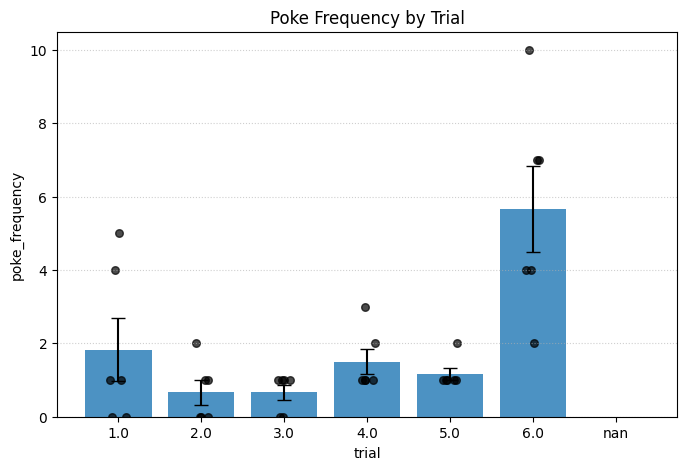

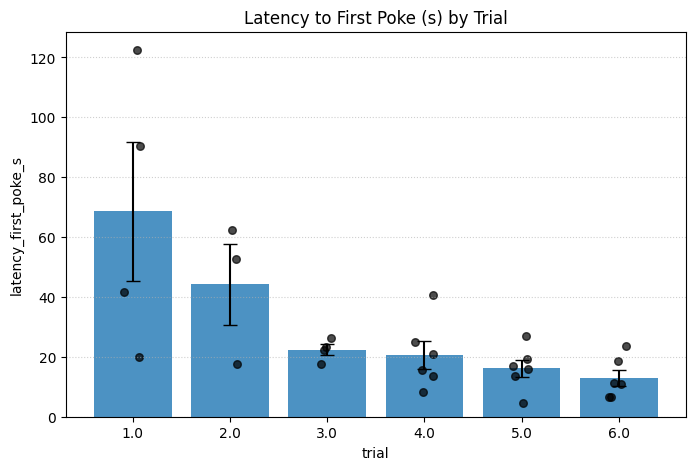

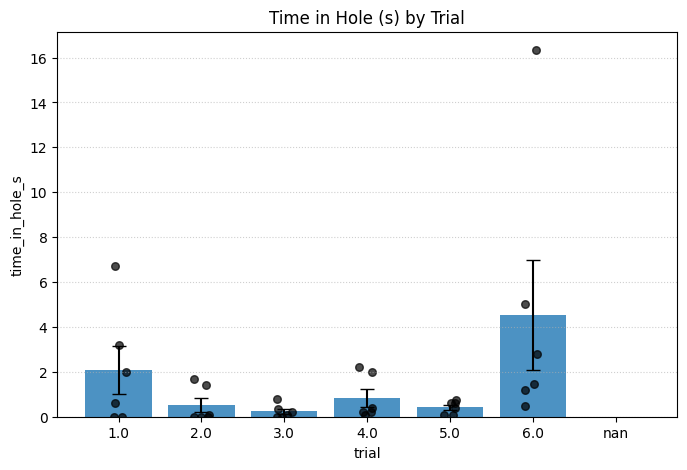

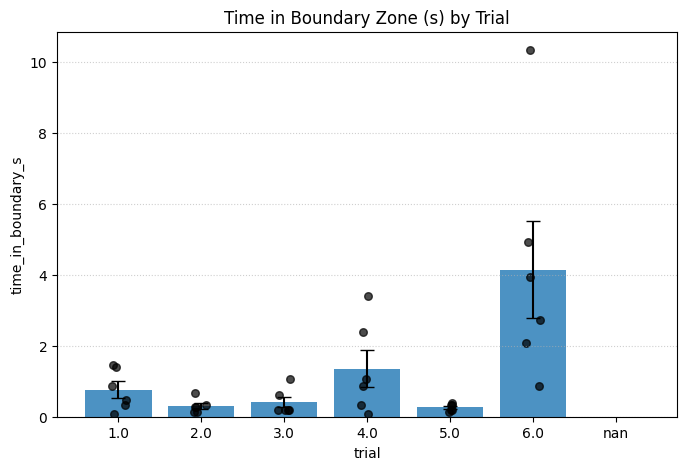

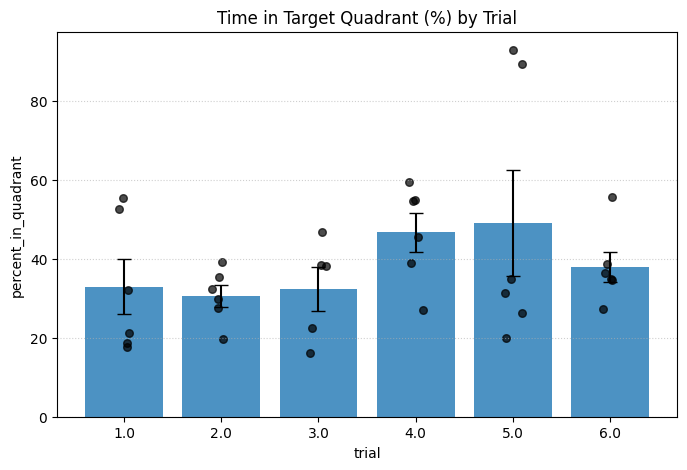

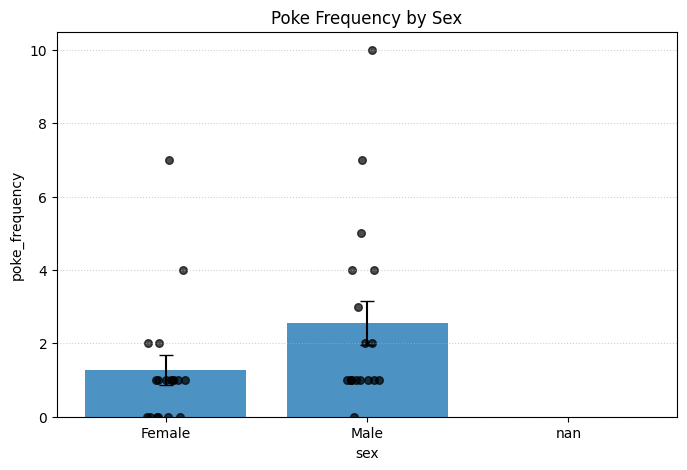

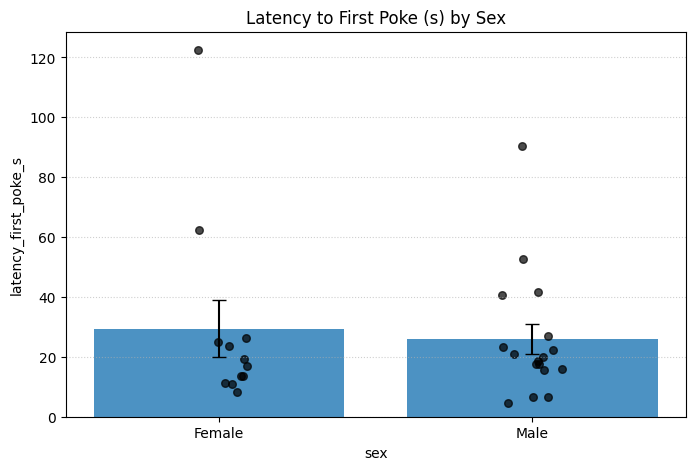

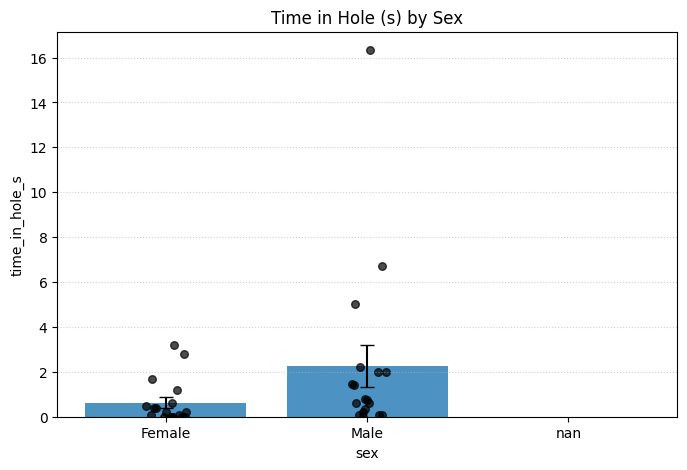

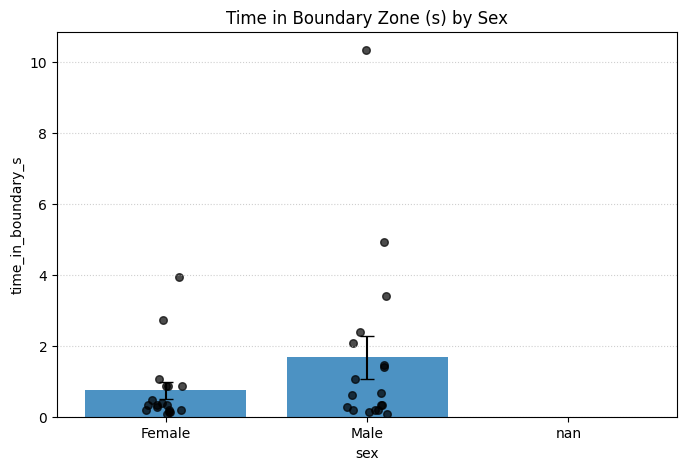

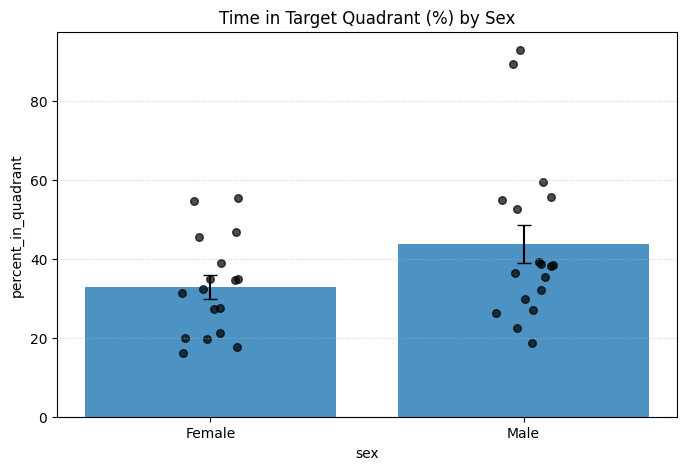

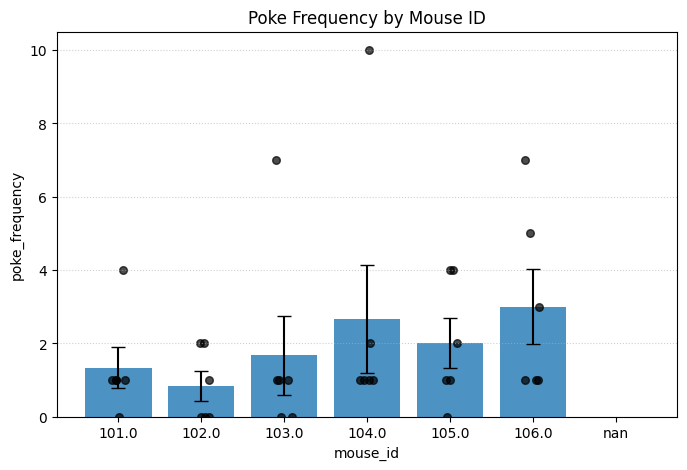

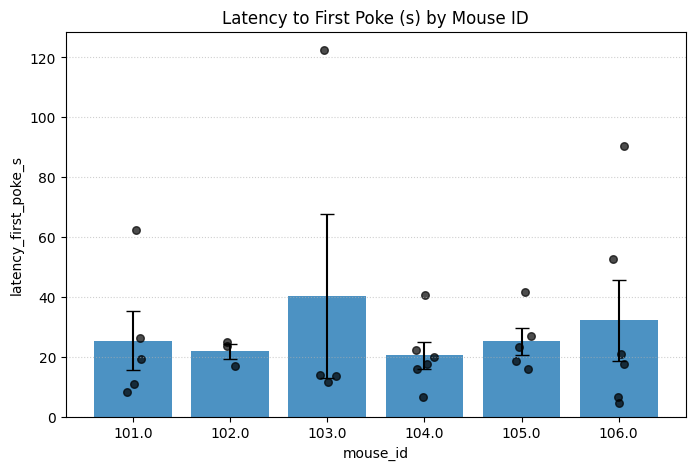

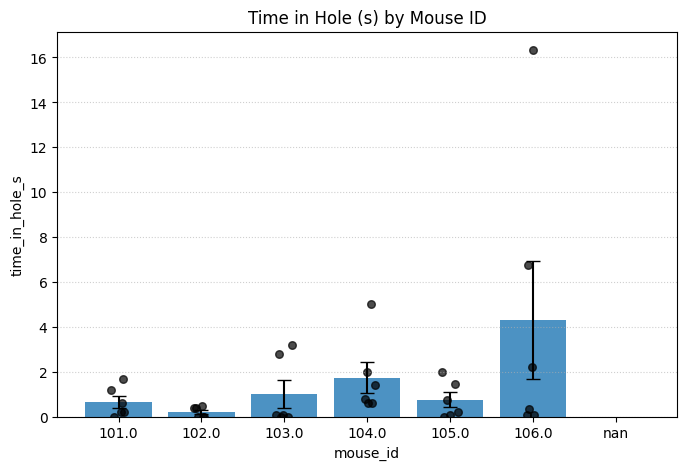

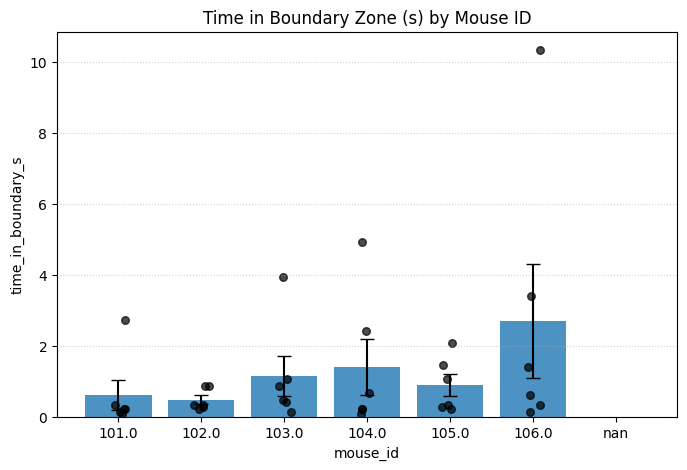

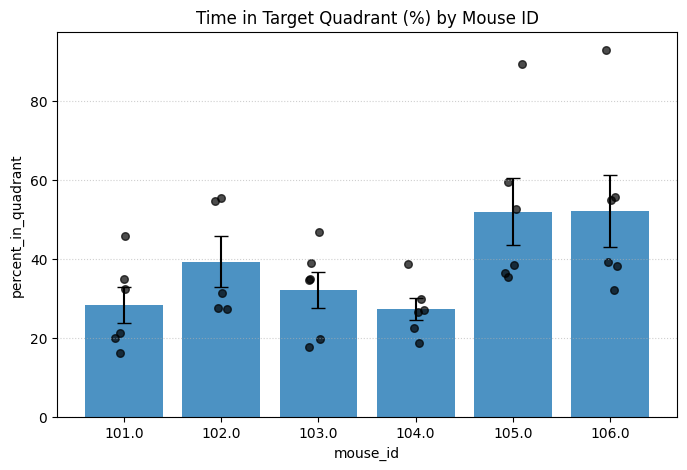

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === helper plotting function ===
def plot_bar_sem_with_points(df_in, group_col, value_col, title, jitter=0.1):
    df = df_in.copy()
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")

    stats = (
        df.groupby(group_col, dropna=False)[value_col]
          .agg(["mean","count","std"])
          .reset_index()
    )
    stats["sem"] = stats["std"] / np.sqrt(stats["count"])

    groups = stats[group_col].tolist()
    means  = stats["mean"].to_numpy()
    sems   = stats["sem"].to_numpy()

    x = np.arange(len(groups))

    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x, means, yerr=sems, capsize=5, alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.set_title(title)
    ax.set_ylabel(value_col)
    ax.set_xlabel(group_col)

    # overlay all points
    for i,g in enumerate(groups):
        pts = df.loc[df[group_col]==g, value_col].dropna()
        xs = np.full(len(pts), x[i]) + np.random.uniform(-jitter, jitter, size=len(pts))
        ax.scatter(xs, pts, s=30, color="black", alpha=0.7)

    ax.grid(axis="y", linestyle=":", alpha=0.6)
    plt.show()

# === metrics to plot ===
METRICS = [
    ("poke_frequency", "Poke Frequency"),
    ("latency_first_poke_s", "Latency to First Poke (s)"),
    ("time_in_hole_s", "Time in Hole (s)"),
    ("time_in_boundary_s", "Time in Boundary Zone (s)"),
    ("percent_in_quadrant", "Time in Target Quadrant (%)"),
]

# --- By trial
for col,label in METRICS:
    plot_bar_sem_with_points(summary_id_trial, "trial", col, f"{label} by Trial")

# --- By sex
for col,label in METRICS:
    plot_bar_sem_with_points(summary_id_trial, "sex", col, f"{label} by Sex")

# --- By mouse_id
for col,label in METRICS:
    plot_bar_sem_with_points(summary_id_trial, "mouse_id", col, f"{label} by Mouse ID")